Importations of libraries

In [1]:
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle 
import os
import shutil
from tqdm.autonotebook import tqdm
from torch_lr_finder import LRFinder
import scipy
path_file  = '/Users/darktanuki/Desktop/Opti of Ml/model' #Enter the path where your want to stock the different models 
path_data =  '/Users/darktanuki/Desktop/Opti of Ml/abalone.data'  #Enter the path where is the abalone dataset

Creation of the NN class and the training functions

In [2]:
class NetFCNN(torch.nn.Module):
    def __init__(self, channels_list=[10,64,64,1]):
        super().__init__()
                         
        self.layers = nn.ModuleList()
        m = len(channels_list)
        for i in range(m-1):
            self.layers.append(nn.Linear(channels_list[i],channels_list[i+1]))


    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = nn.functional.elu(layer(x))
        return x

 

def train_network(network, network_name, train_data, test_data, train_labels, test_labels, batch_size, learning_rate, path_file,
                  criterion = 0.05, nbepochs=10):
        
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    tt=time.time()
    network.train()

    permutation = torch.randperm(train_data.size(0))

    b=0
    for i in range(0, train_data.size(0), batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_p = train_data[indices], train_labels[indices]
        trainLoss =  nn.MSELoss()(network.forward(train_data), train_labels)
        b+=trainLoss
        trainLoss.backward()
        optimizer.step()

    with torch.no_grad():
        outputs= network(test_data)
        testLoss = nn.MSELoss()(outputs, test_labels)
            
    print(f'#{0+1:5d}:' +
          f'test_loss={trainLoss.item():.3e}'
          f' training_loss={trainLoss.item():.3e},' +
          f' time={time.time()-tt:.2f}s')
    tt = time.time()
    
    
    a = 100
    
    print('Training Start...')
    for epoch in range(nbepochs+1):
        c = (a-b)/a
        d = c.detach().numpy()
        if d >= criterion:#criterion: 
            a = b
            b = 0
            permutation = torch.randperm(train_data.size(0))
    
    
            for i in range(0, train_data.size(0), batch_size):
                optimizer.zero_grad()
                indices = permutation[i:i+batch_size]
                batch_x, batch_p = train_data[indices], train_labels[indices]
                trainLoss =  nn.MSELoss()(network.forward(train_data), train_labels)
                b+=trainLoss
                trainLoss.backward()
                optimizer.step()
    
            with torch.no_grad():
                outputs= network(test_data)
                testLoss = nn.MSELoss()(outputs, test_labels)
                    
            print(f'#{epoch+1:5d}:' +
                  f'test_loss={trainLoss.item():.3e}'
                  f' training_loss={trainLoss.item():.3e},' +
                  f' time={time.time()-tt:.2f}s')
            tt = time.time()
        else:
            break
            

    save_dir = path_file + '/' + network_name + '/' + 'weight_localmin.pt'
    torch.save(network.state_dict(), save_dir)
    print('Training Finished!')

Preparation of the dataset 

In [3]:
data = pd.read_csv(path_data)

y = data['15']
Y =y # the label

X = data[['M', '0.455', '0.365', '0.095', '0.514', '0.2245', '0.101', '0.15']]
X['Ma'] = X['M'][X['M']=='M'].replace('M',1)
X['Fe'] = X['M'][X['M']=='F'].replace('F',1)
X['In'] = X['M'][X['M']=='I'].replace('I',1) #transform the label "sex" into 3 differents columns (male, female, infant)
X.replace(np.nan, 0, inplace=True)
del X['M']



p=0.2 # proportions of data that we will use for testset
train_data, test_data, train_labels, test_labels = train_test_split(
    X, y, test_size=p, random_state=42) # split train/test

train_data_ = torch.tensor(train_data.to_numpy()).float()
test_data_ = torch.tensor(test_data.to_numpy()).float()
train_labels_ = torch.tensor(train_labels.to_numpy()).float().reshape((-1,1))
test_labels_ = torch.tensor(test_labels.to_numpy()).float().reshape((-1,1))



a1 = train_data_.mean(axis=0).detach()
b1 = train_data_.std(axis=0).detach()
a2 = train_labels_.mean(axis=0).detach()
b2 = train_labels_.std(axis=0).detach()
data_norm = lambda  x : (x - a1 )  / b1
label_norm = lambda x : (x - a2)  / b2 # normalisation functions


train_data = data_norm(train_data_) 
test_data   = data_norm(test_data_)
train_labels = label_norm(train_labels_) 
test_labels   = label_norm(test_labels_) # normalisation of the data

Find the best learning rate with lr_finder method

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.02E-01


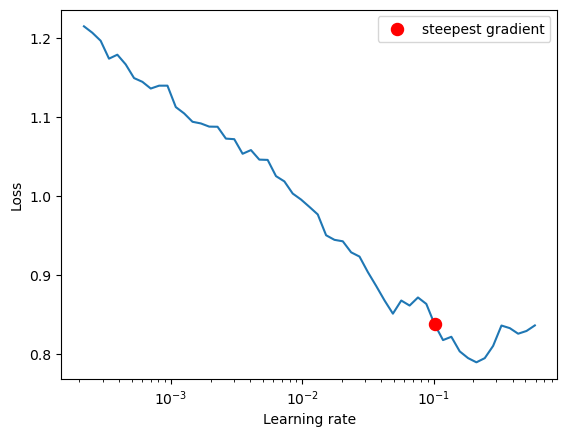

In [4]:
from torch.utils.data import DataLoader, TensorDataset


# Create a TensorDataset to combine the data and labels
dataset = TensorDataset(train_data, train_labels)

# Create a DataLoader using the dataset
batch_size = 64  # Specify the batch size for training
shuffle = True  # Set to True if you want to shuffle the data
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
                         
                         
device = 'cpu'
network =  NetFCNN([10,64,64,1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(),lr=0.00005)
lr_finder = LRFinder(network, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the network and optimizer to their initial state

Creation of n different models 

In [5]:
batch_size = 64
learning_rate = 1.02e-01
device = 'cpu'

n = 50
for i in range(n):
    model_name   = f'model{i}'   # for saving and loading
    print(model_name)
    network = NetFCNN([10,64,64,1]).to(device)
    train_network(network, model_name, train_data, test_data, train_labels, test_labels, batch_size, learning_rate, path_file)


model0
#    1:test_loss=4.940e-01 training_loss=4.940e-01, time=0.19s
Training Start...
#    1:test_loss=4.678e-01 training_loss=4.678e-01, time=0.18s
#    2:test_loss=4.644e-01 training_loss=4.644e-01, time=0.18s
Training Finished!
model1
#    1:test_loss=4.930e-01 training_loss=4.930e-01, time=0.17s
Training Start...
#    1:test_loss=4.785e-01 training_loss=4.785e-01, time=0.19s
#    2:test_loss=4.671e-01 training_loss=4.671e-01, time=0.19s
Training Finished!
model2
#    1:test_loss=5.035e-01 training_loss=5.035e-01, time=0.17s
Training Start...
#    1:test_loss=4.771e-01 training_loss=4.771e-01, time=0.18s
#    2:test_loss=4.636e-01 training_loss=4.636e-01, time=0.17s
Training Finished!
model3
#    1:test_loss=5.046e-01 training_loss=5.046e-01, time=0.17s
Training Start...
#    1:test_loss=4.861e-01 training_loss=4.861e-01, time=0.16s
#    2:test_loss=4.762e-01 training_loss=4.762e-01, time=0.17s
#    3:test_loss=4.709e-01 training_loss=4.709e-01, time=0.16s
Training Finished!
model

#    1:test_loss=4.901e-01 training_loss=4.901e-01, time=0.17s
Training Start...
#    1:test_loss=4.694e-01 training_loss=4.694e-01, time=0.19s
#    2:test_loss=4.591e-01 training_loss=4.591e-01, time=0.19s
Training Finished!
model36
#    1:test_loss=5.002e-01 training_loss=5.002e-01, time=0.17s
Training Start...
#    1:test_loss=4.738e-01 training_loss=4.738e-01, time=0.18s
#    2:test_loss=4.583e-01 training_loss=4.583e-01, time=0.19s
Training Finished!
model37
#    1:test_loss=5.078e-01 training_loss=5.078e-01, time=0.21s
Training Start...
#    1:test_loss=4.844e-01 training_loss=4.844e-01, time=0.20s
#    2:test_loss=4.771e-01 training_loss=4.771e-01, time=0.19s
Training Finished!
model38
#    1:test_loss=5.086e-01 training_loss=5.086e-01, time=0.19s
Training Start...
#    1:test_loss=4.752e-01 training_loss=4.752e-01, time=0.18s
#    2:test_loss=4.706e-01 training_loss=4.706e-01, time=0.17s
Training Finished!
model39
#    1:test_loss=5.095e-01 training_loss=5.095e-01, time=0.17s
T

Get the maximum in a L_inf ball (radius epsilon) around the model{i} (to be able to calculate the sharpness)

In [20]:
def project_weights(network, epsilon):
    with torch.no_grad():
        for i,param in enumerate(network.parameters()):
            param.data = torch.clamp(param.data, -listt[i]*epsilon+listt[i], listt[i]*epsilon+listt[i])
    
    

device = 'cpu'
network = NetFCNN().to(device)


epsilon = 0.025 # Radius of the L_inf ball
nbepochs = 5

for j in range(n):
    print(f"model{j}")

    network.eval()
    localmin_dic = torch.load(path_file+f'/model{j}/weight_localmin.pt')
    network.load_state_dict(localmin_dic)
    
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    
    listt=[]
    for param in network.parameters():
      listt.append(param.clone())
    
    
    maximum_ = 0
    for epoch in range(nbepochs+1):
        permutation = torch.randperm(train_data.size(0))
        tt = time.time()
        maximum=0
        for i in range(0, train_data.size(0), batch_size):
            optimizer.zero_grad()
            
            indices = permutation[i:i+batch_size]
            batch_x, batch_p = train_data[indices], train_labels[indices]
            trainLoss =  -nn.MSELoss()(network(train_data), train_labels)
            trainLoss.backward()
            optimizer.step()
            project_weights(network, epsilon)
            maximum+=nn.MSELoss()(network(train_data), train_labels).detach().numpy()
        print(f'#{epoch+1:5d}:' +
              f'test_loss={trainLoss.item():.3e}'
              f' training_loss={trainLoss.item():.3e},' +
              f' time={time.time()-tt:.2f}s')
        tt = time.time()
    
        if maximum> maximum_:
            save_dir = path_file + '/' + f'model{j}' + '/' + 'weight_localmax.pt'
            torch.save(network.state_dict(), save_dir)
            maximum_ = maximum
            



model0
#    1:test_loss=-5.397e-01 training_loss=-5.397e-01, time=0.27s
#    2:test_loss=-5.414e-01 training_loss=-5.414e-01, time=0.25s
#    3:test_loss=-5.417e-01 training_loss=-5.417e-01, time=0.26s
#    4:test_loss=-5.418e-01 training_loss=-5.418e-01, time=0.26s
#    5:test_loss=-5.418e-01 training_loss=-5.418e-01, time=0.25s
#    6:test_loss=-5.419e-01 training_loss=-5.419e-01, time=0.25s
model1
#    1:test_loss=-5.379e-01 training_loss=-5.379e-01, time=0.25s
#    2:test_loss=-5.419e-01 training_loss=-5.419e-01, time=0.25s
#    3:test_loss=-5.423e-01 training_loss=-5.423e-01, time=0.25s
#    4:test_loss=-5.425e-01 training_loss=-5.425e-01, time=0.25s
#    5:test_loss=-5.425e-01 training_loss=-5.425e-01, time=0.25s
#    6:test_loss=-5.426e-01 training_loss=-5.426e-01, time=0.25s
model2
#    1:test_loss=-5.282e-01 training_loss=-5.282e-01, time=0.25s
#    2:test_loss=-5.327e-01 training_loss=-5.327e-01, time=0.25s
#    3:test_loss=-5.332e-01 training_loss=-5.332e-01, time=0.25s
#   

#    5:test_loss=-5.306e-01 training_loss=-5.306e-01, time=0.27s
#    6:test_loss=-5.306e-01 training_loss=-5.306e-01, time=0.29s
model21
#    1:test_loss=-5.371e-01 training_loss=-5.371e-01, time=0.29s
#    2:test_loss=-5.398e-01 training_loss=-5.398e-01, time=0.27s
#    3:test_loss=-5.403e-01 training_loss=-5.403e-01, time=0.29s
#    4:test_loss=-5.405e-01 training_loss=-5.405e-01, time=0.26s
#    5:test_loss=-5.406e-01 training_loss=-5.406e-01, time=0.27s
#    6:test_loss=-5.406e-01 training_loss=-5.406e-01, time=0.28s
model22
#    1:test_loss=-5.338e-01 training_loss=-5.338e-01, time=0.28s
#    2:test_loss=-5.366e-01 training_loss=-5.366e-01, time=0.27s
#    3:test_loss=-5.370e-01 training_loss=-5.370e-01, time=0.27s
#    4:test_loss=-5.372e-01 training_loss=-5.372e-01, time=0.26s
#    5:test_loss=-5.372e-01 training_loss=-5.372e-01, time=0.26s
#    6:test_loss=-5.373e-01 training_loss=-5.373e-01, time=0.26s
model23
#    1:test_loss=-5.393e-01 training_loss=-5.393e-01, time=0.26s
#

#    3:test_loss=-5.517e-01 training_loss=-5.517e-01, time=0.26s
#    4:test_loss=-5.519e-01 training_loss=-5.519e-01, time=0.29s
#    5:test_loss=-5.520e-01 training_loss=-5.520e-01, time=0.27s
#    6:test_loss=-5.520e-01 training_loss=-5.520e-01, time=0.26s
model42
#    1:test_loss=-5.385e-01 training_loss=-5.385e-01, time=0.26s
#    2:test_loss=-5.410e-01 training_loss=-5.410e-01, time=0.26s
#    3:test_loss=-5.414e-01 training_loss=-5.414e-01, time=0.26s
#    4:test_loss=-5.416e-01 training_loss=-5.416e-01, time=0.26s
#    5:test_loss=-5.417e-01 training_loss=-5.417e-01, time=0.26s
#    6:test_loss=-5.417e-01 training_loss=-5.417e-01, time=0.27s
model43
#    1:test_loss=-5.359e-01 training_loss=-5.359e-01, time=0.31s
#    2:test_loss=-5.390e-01 training_loss=-5.390e-01, time=0.29s
#    3:test_loss=-5.393e-01 training_loss=-5.393e-01, time=0.28s
#    4:test_loss=-5.393e-01 training_loss=-5.393e-01, time=0.26s
#    5:test_loss=-5.394e-01 training_loss=-5.394e-01, time=0.30s
#    6:te

Get the sharpness and the test_losses 

In [6]:
n=50
device = 'cpu'

localmin = NetFCNN().to(device)
localmax = NetFCNN().to(device)
sharpnesses = np.zeros(n)
test_losses = np.zeros(n)

for j in range(n):
    
    localmin_dic = torch.load(path_file+f'/model{j}/weight_localmin.pt')
    localmin.load_state_dict(localmin_dic)
    
    localmax_dic = torch.load(path_file+f'/model{j}/weight_localmax.pt')
    localmax.load_state_dict(localmax_dic)
    
        
    with torch.no_grad():
        outputsmax= localmax(train_data)
        outputsmin= localmin(train_data)
        
        Max  = nn.MSELoss()(outputsmax, train_labels)
        Min  = nn.MSELoss()(outputsmin, train_labels)
        
        
        outputsminTest = localmin(test_data)
        MinTest= nn.MSELoss()(outputsminTest, test_labels) 
        
    sharpnesses[j] = Max.item()-Min.item()
    test_losses[j]   = MinTest.item()



Plot sharpnesses / test_losses with calculation of kendall tau correlation

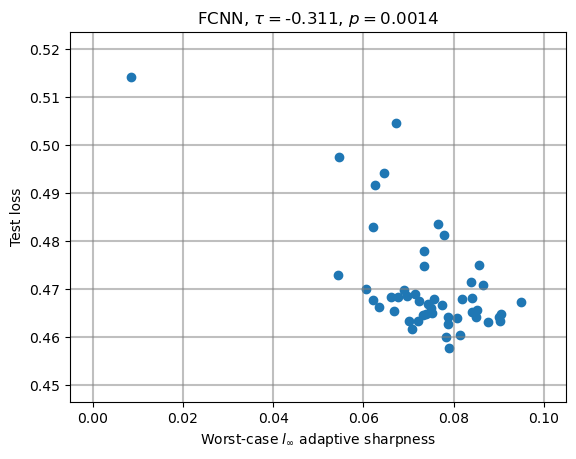

In [7]:

tau, pval = scipy.stats.kendalltau(sharpnesses, test_losses)
plt.scatter(sharpnesses, test_losses)

# Add grey vertical lines
for x in plt.xticks()[0]:
    plt.axvline(x=x, color='grey', alpha=0.5)

# Add grey horizontal lines
for y in plt.yticks()[0]:
    plt.axhline(y=y, color='grey', alpha=0.5)

# Set labels and title
plt.xlabel('Worst-case '+r'$l_{\infty}$'+' adaptive sharpness')
plt.ylabel('Test loss')
plt.title('FCNN, '+r'$\tau=$'+ f'{tau:.3f}' + r', $p=$' + f'{pval:.4f}')
plt.savefig('FCNN.png')

# Display the plot
plt.show()